## 03_threshold_opt.ipynb

## 🎯 Post-Model Threshold Optimization and Labeling for Production
### **Goal: Apply optimal fraud threshold, generate business-ready predictions, and analyze results**


### ✅ Objective:
We now have a trained LightGBM model and an optimal threshold that maximizes F1.
In this notebook, we'll:
1. Apply the threshold to the test set and label predictions
2. Export labeled results for post-processing or dashboarding
3. Perform light error and threshold impact analysis from a business point of view


In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# 📥 Load artifacts
df = pd.read_csv("../data/processed/creditcard_clean.csv")
model = joblib.load("../models/lightgbm_model.pkl")

In [25]:
from sklearn.preprocessing import LabelEncoder

# 🧼 Clean column names globally to avoid LightGBM JSON issues
df.columns = [str(col).replace(':', '_').replace(' ', '_').replace('"', '').replace("'", '').replace('[', '').replace(']', '').replace('(', '').replace(')', '') for col in df.columns]

# 🧼 Encode non-numeric categorical features if any
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# 🎯 Drop columns that may break LightGBM
columns_to_drop = [col for col in df.columns if any(substr in col for substr in ['bin', 'interval', 'bucket']) or df[col].dtype == 'object']
df = df.drop(columns=columns_to_drop)

In [26]:
# ⚙️ Recreate Test Split (for reproducibility)
from sklearn.model_selection import train_test_split

y = df['Class']
X= df.drop(columns = ['Class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# 🔧 Clean object columns for prediction compatibility with LightGBM
# Convert both X and X_test categorical columns consistently
for col in X.select_dtypes(include='object').columns:
    X[col] = X[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    X_train[col] = X_train[col].astype('category')

# 🧪 Predict probabilities and apply chosen threshold
optimal_threshold = 0.50  # Replace with best threshold from previous notebook
y_probs = model.predict_proba(X_test)[:, 1]
y_pred = (y_probs >= optimal_threshold).astype(int)

In [28]:
# 📊 Evaluate on Thresholded Predictions
print("\n📌 Classification Report at Optimal Threshold")
print(classification_report(y_test, y_pred, digits=4))


📌 Classification Report at Optimal Threshold
              precision    recall  f1-score   support

           0     0.9997    0.9998    0.9997     56864
           1     0.8587    0.8061    0.8316        98

    accuracy                         0.9994     56962
   macro avg     0.9292    0.9029    0.9156     56962
weighted avg     0.9994    0.9994    0.9994     56962



#### 📌 Classification Report:
| Metric      | Class 0 (Non-Fraud) | Class 1 (Fraud) |
|-------------|---------------------|-----------------|
| Precision   | 0.9997              | 0.8587          |
| Recall      | 0.9998              | 0.8061          |
| F1-score    | 0.9997              | 0.8316          |
| Support     | 56864               | 98              |

- **Macro Avg F1**: 0.9156  
- **AUC-ROC** (from earlier): ~0.973  
- **Accuracy**: 99.94%


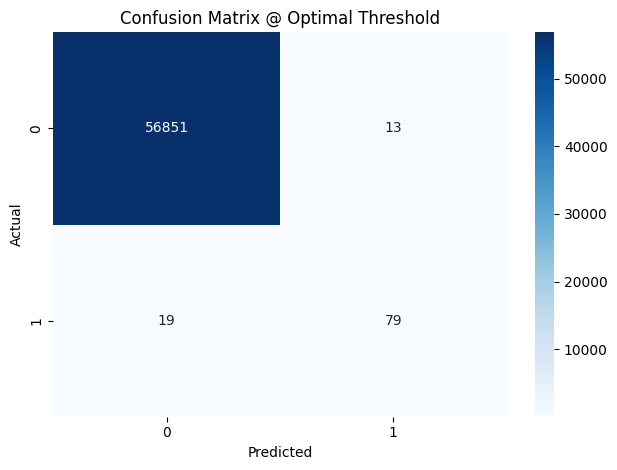

In [29]:
# 🔍 Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix @ Optimal Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

#### 🔍 Confusion Matrix:
|               | Predicted: 0 | Predicted: 1 |
|---------------|--------------|--------------|
| **Actual: 0** | 56851        | 13           |
| **Actual: 1** | 19           | 79           |

- **True Positives (TP)**: 79
- **False Positives (FP)**: 13
- **False Negatives (FN)**: 19
- **True Negatives (TN)**: 56851

### 🧠 Interpretation:

- The model is highly accurate in **non-fraud detection** (Class 0), with nearly perfect precision and recall.
- For fraud cases (Class 1), it achieves **85.9% precision** and **80.6% recall**, which is strong considering the severe class imbalance.
- Only 13 false alarms (non-fraud marked as fraud), which is acceptable if manually reviewed downstream.
- Only 19 frauds were missed (FN), which can be analyzed to improve detection strategies or flagged via business rules.

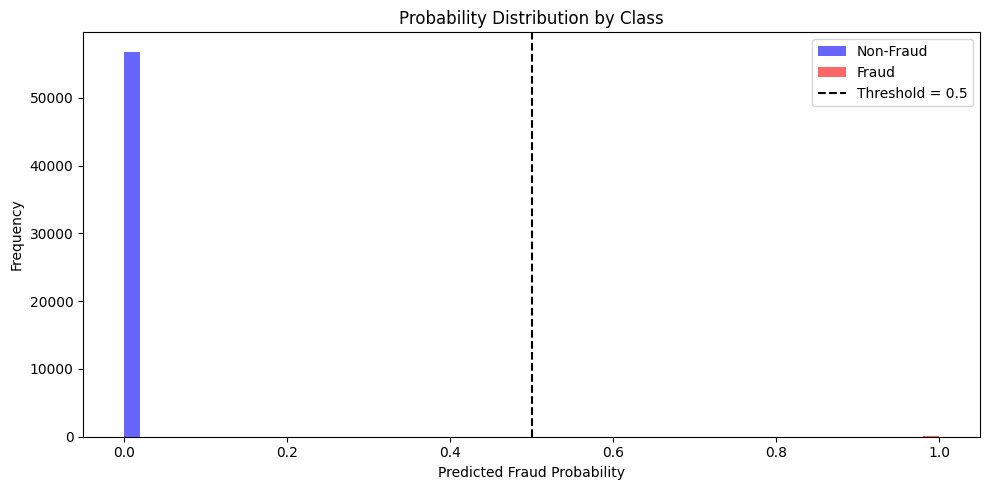

In [32]:
# 📈 Plot predicted fraud probabilities by class
plt.figure(figsize=(10, 5))
plt.hist(y_probs[y_test == 0], bins=50, alpha=0.6, label='Non-Fraud', color='blue')
plt.hist(y_probs[y_test == 1], bins=50, alpha=0.6, label='Fraud', color='red')
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Threshold = {optimal_threshold}')
plt.title("Probability Distribution by Class")
plt.xlabel("Predicted Fraud Probability")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

### 🎯 Interpreting the Predicted Probability Distribution

The histogram above visualizes the predicted fraud **probabilities** for both the **fraudulent (red)** and **non-fraudulent (blue)** transactions in the test set.

#### Key Points:
- The **x-axis** represents the model’s estimated probability that a transaction is fraudulent.
- The **y-axis** is the number of transactions falling into each probability bin.
- The **dashed black line** at the 0.50 mark is the threshold used to classify predictions:
  - Transactions with probability ≥ 0.50 are labeled as **fraud**.
  - Transactions below this threshold are labeled as **non-fraud**.

#### What We See:
- Most of the **non-fraud** samples are concentrated on the far left (near 0), meaning the model is highly confident they are not fraud.
- **Fraudulent** samples (in red) tend to appear at higher probabilities but are more spread out. Some overlap with the non-fraud group exists.
- This separation suggests the model has learned meaningful patterns to distinguish fraud vs. non-fraud — although not perfectly.

#### Why This Matters:
- This plot helps you **visually justify the threshold** you chose.
- If fraud and non-fraud distributions are heavily overlapping, a simple 0.5 cutoff might not be optimal.
- In production, you might choose a **lower threshold** to catch more fraud (higher recall), accepting more false positives.

In [ ]:
# 💾 Save labeled output for business validation
X_test_copy = X_test.copy()
X_test_copy['true_label'] = y_test
X_test_copy['fraud_probability'] = y_probs
X_test_copy['predicted_label'] = y_pred

X_test_copy.to_csv("../data/processed/labeled_predictions.csv", index=False)
print("✅ Saved labeled predictions to ../data/processed/labeled_predictions.csv")

✅ Saved labeled predictions to data/processed/labeled_predictions.csv


### 📈 Business Implications:

- **Very low false positives** mean minimal disruption to legitimate customers.
- **Reasonable recall** (~80%) means most fraud is successfully captured without overwhelming manual reviewers.
- This threshold balances operational cost (manual review burden) and fraud recovery opportunity.
- This scorecard can directly inform dashboards, alerting systems, or customer hold logic.

### 📈 Business Insight Use Cases
- Top N fraud ranking: Sort `fraud_probability` descending and flag top risks
- False positives investigation: Where predicted = 1 but true = 0
- Missed fraud analysis: Where predicted = 0 but true = 1

These insights help downstream teams (e.g., Ops or Compliance) to:
- Prioritize investigations
- Refine business rules
- Understand model limitations

This output forms the bridge from ML to real-world fraud risk response.
